In [1]:
from io import open
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

use_cuda = torch.cuda.is_available()
CUDA_DEVICE = 1

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(r"([,.!?])", r" \1", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [4]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('./%s-%s.txt' % (lang1, lang2)).\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [5]:
MAX_LENGTH = 8

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 300108 sentence pairs
Trimmed to 184175 sentence pairs
Counting words...
Counted words:
rus 35877
eng 12383
['могу я пойти с тобой ?', 'may i go with you ?']


In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda(CUDA_DEVICE)
        else:
            return result

In [8]:
class Attn(nn.Module):
    def __init__(self, hidden_size):
        super(Attn, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.normal_(mean=0, std=stdv)
        torch.nn.init.xavier_uniform(self.attn.weight)

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        H = hidden.repeat(max_len,1,1)
        encoder_outputs = encoder_outputs.unsqueeze(1)
        
        attn_energies = self.score(H,encoder_outputs) # compute attention score
        attn_energies = F.softmax(attn_energies.transpose(1,0), dim = 1) # normalize with softmax
        return attn_energies

    def score(self, hidden, encoder_outputs):
        energy = F.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(2,1)
        v = self.v.repeat(encoder_outputs.data.shape[0],1).unsqueeze(1)
        energy = torch.bmm(v,energy)
        return energy.squeeze(1)

In [9]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn_new = Attn(hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = self.attn_new.forward(hidden, encoder_outputs)
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda(CUDA_DEVICE)
        else:
            return result

In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda(CUDA_DEVICE)
    else:
        return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [11]:
teacher_forcing_ratio = 0.5


def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda(CUDA_DEVICE) if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda(CUDA_DEVICE) if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda(CUDA_DEVICE) if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()
    
    # Если решите использовать  Adam, то лучше клипать градиенты
    #torch.nn.utils.clip_grad_norm(encoder.parameters(), 1)
    #torch.nn.utils.clip_grad_norm(encoder.parameters(), 1)
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [12]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [13]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.001):
    encoder.train()
    decoder.train()
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
    # Можно попробовать заюзать Adam
    #encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    #decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [14]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [15]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    encoder.eval()
    decoder.eval()
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda(CUDA_DEVICE) if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda(CUDA_DEVICE) if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda(CUDA_DEVICE) if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

In [16]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

0m 11s (- 142m 40s) (100 0%) 5.8456
0m 14s (- 91m 32s) (200 0%) 5.5004
0m 18s (- 74m 54s) (300 0%) 5.2732
0m 21s (- 66m 46s) (400 0%) 5.0431
0m 24s (- 61m 21s) (500 0%) 5.1094
0m 27s (- 57m 46s) (600 0%) 4.9128
0m 31s (- 55m 3s) (700 0%) 4.9440
0m 34s (- 53m 6s) (800 1%) 4.7994
0m 37s (- 51m 26s) (900 1%) 4.7742
0m 40s (- 50m 13s) (1000 1%) 4.6408
0m 44s (- 49m 46s) (1100 1%) 4.8178
0m 47s (- 49m 2s) (1200 1%) 4.7144
0m 51s (- 48m 58s) (1300 1%) 4.7970
0m 55s (- 48m 25s) (1400 1%) 4.6482
0m 59s (- 48m 26s) (1500 2%) 4.5068
1m 3s (- 48m 47s) (1600 2%) 4.6676
1m 8s (- 49m 8s) (1700 2%) 4.4785
1m 12s (- 49m 22s) (1800 2%) 4.4752
1m 17s (- 49m 27s) (1900 2%) 4.6467
1m 22s (- 49m 56s) (2000 2%) 4.6320
1m 26s (- 50m 12s) (2100 2%) 4.5456
1m 30s (- 50m 8s) (2200 2%) 4.5260
1m 35s (- 50m 10s) (2300 3%) 4.5458
1m 39s (- 50m 17s) (2400 3%) 4.3936
1m 44s (- 50m 35s) (2500 3%) 4.6729
1m 49s (- 50m 38s) (2600 3%) 4.4344
1m 54s (- 50m 55s) (2700 3%) 4.3545
1m 58s (- 51m 5s) (2800 3%) 4.2961
2m 3s (-

15m 30s (- 36m 52s) (22200 29%) 3.2615
15m 34s (- 36m 48s) (22300 29%) 3.3345
15m 37s (- 36m 41s) (22400 29%) 3.2196
15m 41s (- 36m 36s) (22500 30%) 3.0837
15m 45s (- 36m 32s) (22600 30%) 3.3340
15m 50s (- 36m 28s) (22700 30%) 3.3418
15m 54s (- 36m 24s) (22800 30%) 3.0744
15m 58s (- 36m 20s) (22900 30%) 3.1816
16m 2s (- 36m 15s) (23000 30%) 3.2684
16m 6s (- 36m 12s) (23100 30%) 3.2133
16m 10s (- 36m 7s) (23200 30%) 3.3386
16m 14s (- 36m 3s) (23300 31%) 3.3958
16m 19s (- 35m 59s) (23400 31%) 3.1439
16m 23s (- 35m 55s) (23500 31%) 3.2089
16m 27s (- 35m 51s) (23600 31%) 3.1389
16m 31s (- 35m 46s) (23700 31%) 3.2382
16m 36s (- 35m 43s) (23800 31%) 3.3516
16m 41s (- 35m 40s) (23900 31%) 3.0005
16m 45s (- 35m 35s) (24000 32%) 3.3048
16m 48s (- 35m 30s) (24100 32%) 3.3526
16m 53s (- 35m 27s) (24200 32%) 3.1904
16m 58s (- 35m 25s) (24300 32%) 3.2598
17m 3s (- 35m 23s) (24400 32%) 3.0159
17m 8s (- 35m 19s) (24500 32%) 3.2268
17m 12s (- 35m 15s) (24600 32%) 3.4134
17m 15s (- 35m 9s) (24700 32%) 

30m 1s (- 21m 51s) (43400 57%) 2.9027
30m 5s (- 21m 47s) (43500 57%) 2.8214
30m 9s (- 21m 42s) (43600 58%) 2.8659
30m 12s (- 21m 38s) (43700 58%) 2.8112
30m 16s (- 21m 33s) (43800 58%) 2.8736
30m 20s (- 21m 29s) (43900 58%) 2.9937
30m 24s (- 21m 25s) (44000 58%) 2.8549
30m 29s (- 21m 21s) (44100 58%) 2.6580
30m 33s (- 21m 17s) (44200 58%) 2.8507
30m 37s (- 21m 13s) (44300 59%) 2.8587
30m 41s (- 21m 8s) (44400 59%) 2.9765
30m 45s (- 21m 4s) (44500 59%) 2.7690
30m 49s (- 21m 0s) (44600 59%) 2.9277
30m 53s (- 20m 56s) (44700 59%) 2.8274
30m 57s (- 20m 52s) (44800 59%) 2.5131
31m 1s (- 20m 48s) (44900 59%) 2.8602
31m 5s (- 20m 43s) (45000 60%) 2.8443
31m 9s (- 20m 39s) (45100 60%) 2.8355
31m 14s (- 20m 35s) (45200 60%) 2.7238
31m 17s (- 20m 31s) (45300 60%) 2.6567
31m 21s (- 20m 26s) (45400 60%) 2.7817
31m 25s (- 20m 22s) (45500 60%) 2.7505
31m 29s (- 20m 18s) (45600 60%) 2.7781
31m 33s (- 20m 14s) (45700 60%) 2.8492
31m 37s (- 20m 9s) (45800 61%) 2.8757
31m 42s (- 20m 6s) (45900 61%) 2.79

44m 36s (- 7m 6s) (64700 86%) 2.5305
44m 40s (- 7m 1s) (64800 86%) 2.5652
44m 45s (- 6m 57s) (64900 86%) 2.5322
44m 50s (- 6m 53s) (65000 86%) 2.4938
44m 55s (- 6m 49s) (65100 86%) 2.5194
44m 58s (- 6m 45s) (65200 86%) 2.3772
45m 3s (- 6m 41s) (65300 87%) 2.5350
45m 7s (- 6m 37s) (65400 87%) 2.6644
45m 11s (- 6m 33s) (65500 87%) 2.6172
45m 15s (- 6m 29s) (65600 87%) 2.3776
45m 19s (- 6m 24s) (65700 87%) 2.3530
45m 23s (- 6m 20s) (65800 87%) 2.6415
45m 28s (- 6m 16s) (65900 87%) 2.2741
45m 32s (- 6m 12s) (66000 88%) 2.4746
45m 36s (- 6m 8s) (66100 88%) 2.7553
45m 41s (- 6m 4s) (66200 88%) 2.5258
45m 45s (- 6m 0s) (66300 88%) 2.6183
45m 50s (- 5m 56s) (66400 88%) 2.5446
45m 54s (- 5m 52s) (66500 88%) 2.3837
45m 57s (- 5m 47s) (66600 88%) 2.7907
46m 2s (- 5m 43s) (66700 88%) 2.4769
46m 6s (- 5m 39s) (66800 89%) 2.6311
46m 10s (- 5m 35s) (66900 89%) 2.4288
46m 14s (- 5m 31s) (67000 89%) 2.4085
46m 18s (- 5m 27s) (67100 89%) 2.6899
46m 22s (- 5m 22s) (67200 89%) 2.3665
46m 26s (- 5m 18s) (6

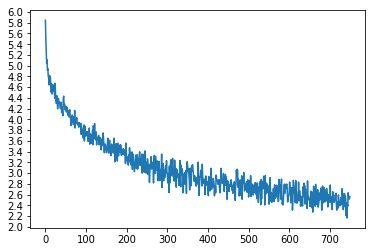

In [17]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)


if use_cuda:
    encoder1 = encoder1.cuda(CUDA_DEVICE)
    attn_decoder1 = attn_decoder1.cuda(CUDA_DEVICE)

trainIters(encoder1, attn_decoder1, 75000, print_every=100)

In [18]:
evaluateRandomly(encoder1, attn_decoder1)

> где я могу купить конвертов ?
= where can i buy envelopes ?
< where can i buy buy ? <EOS>

> том очень разозлился .
= tom became very angry .
< tom is very . . <EOS>

> никто не знает ответ .
= nobody knows the answer .
< nobody knows the answer . <EOS>

> она живёт в огромном доме .
= she lives in a huge house .
< she lives in the house . <EOS>

> том не сам это сделал .
= tom didn't do that himself .
< tom didn't do that by . <EOS>

> том врёт ?
= is tom lying ?
< is tom ? ? <EOS>

> я схватил её за руку .
= i caught her by the hand .
< i put it . . <EOS>

> я пошёл на прогулку .
= i took a walk .
< i went to a . . <EOS>

> у вас есть охотничья лицензия ?
= do you have a hunting license ?
< do you have a a ? ? <EOS>

> мы должны идти теперь .
= we must go now .
< we should go . <EOS>



In [19]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = меня зовут том .
output = i was tom tom . <EOS>


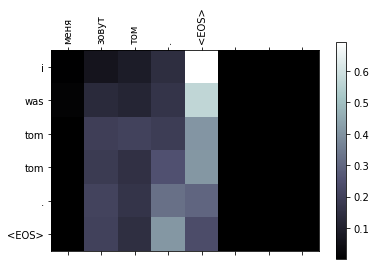

In [20]:
evaluateAndShowAttention("меня зовут том .")

input = я приехал вчера вечером .
output = i was married last night . <EOS>


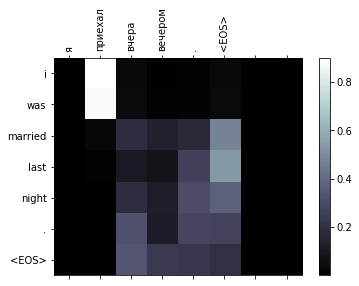

In [21]:
evaluateAndShowAttention("я приехал вчера вечером .")

input = куда положить деньги .
output = i put money . <EOS>


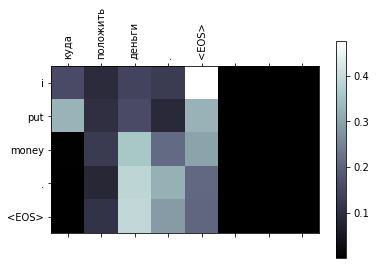

In [22]:
evaluateAndShowAttention("куда положить деньги .")

input = том даже не живёт в бостоне .
output = tom didn't want to boston . . <EOS>


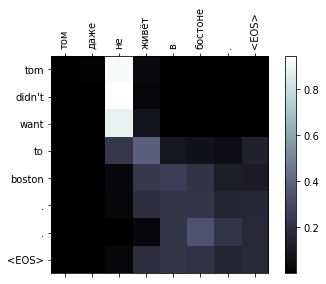

In [23]:
evaluateAndShowAttention("том даже не живёт в бостоне .")